# Homework Assignment 5

## Topics: Variable engineering, feature interactions, Strong Heredity Principle

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## 1. Using pandas to read the data files

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
## Creating variables from Homework Assignment 4

## Training set:

## Variable 1 (from decision tree)
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (train['lineItemVoids'] <= 10.5), 0, 1)
## Variable 2 (from decision tree)
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] > 0.012) & 
                                  (train['totalScanTimeInSeconds'] <= 895.0), 0, 1)
## Variable 3 (from decision tree)
train['Interaction_3'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] <= 99.145) & 
                                  train['trustLevel'] <= 2.5, 1, 0)
## Variable 4 (from decision tree)
train['Interaction_4'] = np.where((train['trustLevel'] > 1.5) & (train['grandTotal'] > 99.145) & 
                                  train['valuePerSecond'] <= 0.06, 1, 0)
## Variable 5 - Low trustLevel (all frauds came from trustLevel = 1 or 2)
train['lowTrust'] = np.where(train['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
train['madeModification'] = np.where(train['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
train['madeScansWithoutRegistration'] = np.where(train['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds (huge differnece in mean and median values for fraud/not fraud in this field)
train['lowTotalScanTime'] = np.where(train['totalScanTimeInSeconds'] < 1000, 1, 0)



## Testing set:

## Variable 1
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & 
                                  (test['lineItemVoids'] <= 10.5), 0, 1)
## Variable 2
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] > 0.012) & 
                                  (test['totalScanTimeInSeconds'] <= 895.0), 0, 1)
## Variable 3
test['Interaction_3'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] <= 99.145) & 
                                  test['trustLevel'] <= 2.5, 1, 0)
## Variable 4
test['Interaction_4'] = np.where((test['trustLevel'] > 1.5) & (test['grandTotal'] > 99.145) & 
                                  test['valuePerSecond'] <= 0.06, 1, 0)
## Variable 5 - Low trustLevel
test['lowTrust'] = np.where(test['trustLevel'] <= 2, 1, 0)

## Variable 6 - Made a quantity modification
test['madeModification'] = np.where(test['quantityModifications'] > 0, 1, 0)

## Variable 7 - Attempted a scan without registration
test['madeScansWithoutRegistration'] = np.where(test['scansWithoutRegistration'] > 0, 1, 0)

## Variable 8 - High or low totalScanTimeInSeconds
test['lowTotalScanTime'] = np.where(test['totalScanTimeInSeconds'] < 1000, 1, 0)

In [3]:
## 2. Using the train data-frame and the features that were engineered in homework assignment 4 to engineer at 
## least four interactions as follows:

## a) Engineering three feature by using the strong heredity principle. That is, identifying the top three features and 
## engineering the interaction between them


## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Defining a list to store results
results = []

## Repeating process 100 times
for i in range(0, 100):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    rf_md = RandomForestClassifier(max_depth = 3, n_estimators = 500).fit(X_train, Y_train)
    
    ## Extracting feature importance scores
    results.append(rf_md.feature_importances_)
    
## Changing results list to a dataframe
results = pd.DataFrame(results, columns = X.columns)

## Computing averages and sorting variables by importance
results = pd.DataFrame(results.apply(np.mean, axis = 0))
results = pd.DataFrame({'Feature': results.index, 'Importance': results[0].values}).sort_values(by = 'Importance', ascending = False)

results

,Feature,Importance
0,trustLevel,0.293684
13,lowTrust,0.173354
6,scannedLineItemsPerSecond,0.113008
8,lineItemVoidsPerPosition,0.092760
1,totalScanTimeInSeconds,0.079362
10,Interaction_2,0.051640
7,valuePerSecond,0.044975
2,grandTotal,0.032657
9,Interaction_1,0.028942
3,lineItemVoids,0.027869


In [4]:
## trustLevel, lowTrust, and scannedLineItemsPerSecond are the three most influential variables for the
## Random Forest Classifier model on average. 

## Now, engineering three features by using the strong heredity principle 

train['Heredity_Feature_1'] = train['trustLevel'] * train['lowTrust']
train['Heredity_Feature_2'] = train['trustLevel'] * train['scannedLineItemsPerSecond']
train['Heredity_Feature_3'] = train['lowTrust'] * train['scannedLineItemsPerSecond']

[Text(537.075, 880.6320000000001, 'Heredity_Feature_3 <= 0.012\ngini = 0.104\nsamples = 1503\nvalue = [1420, 83]'),
 Text(460.35, 684.936, 'gini = 0.0\nsamples = 1138\nvalue = [1138, 0]'),
 Text(613.8000000000001, 684.936, 'totalScanTimeInSeconds <= 1298.0\ngini = 0.351\nsamples = 365\nvalue = [282, 83]'),
 Text(306.90000000000003, 489.24, 'Heredity_Feature_1 <= 1.5\ngini = 0.23\nsamples = 287\nvalue = [249, 38]'),
 Text(153.45000000000002, 293.544, 'valuePerSecond <= 0.119\ngini = 0.378\nsamples = 146\nvalue = [109, 37]'),
 Text(76.72500000000001, 97.84800000000007, 'gini = 0.485\nsamples = 80\nvalue = [47, 33]'),
 Text(230.175, 97.84800000000007, 'gini = 0.114\nsamples = 66\nvalue = [62, 4]'),
 Text(460.35, 293.544, 'scansWithoutRegistration <= 9.5\ngini = 0.014\nsamples = 141\nvalue = [140, 1]'),
 Text(383.62500000000006, 97.84800000000007, 'gini = 0.0\nsamples = 123\nvalue = [123, 0]'),
 Text(537.075, 97.84800000000007, 'gini = 0.105\nsamples = 18\nvalue = [17, 1]'),
 Text(920.7, 4

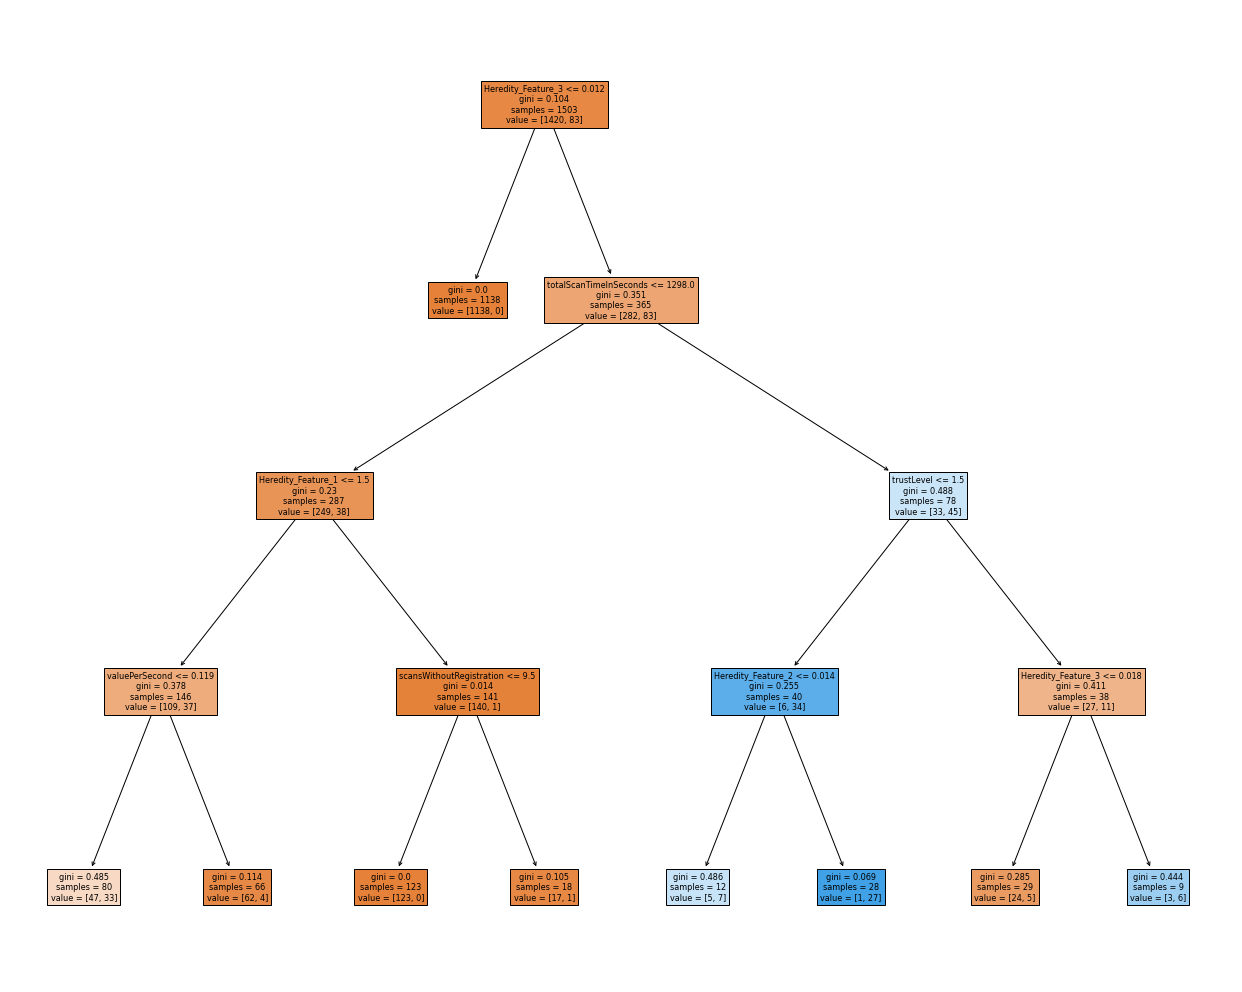

In [6]:
## 2. b) Engineering at least one feature by building a decision tree model (with depth at most equal to 4) on the train 
## data-frame and identifying interesting patterns in the decision tree

## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 4).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (22, 18))
plot_tree(tree_md, feature_names = X.columns, filled = True)

In [7]:
## Now, engineering three features by using the decision tree model

## Heredity_Feature_3: all observations less than 0.012 are not fraud in this tree
train['New_Interaction_1'] = np.where(train['Heredity_Feature_3'] <= 0.012, 1, 0)

## Lots of positove observations when Heredity_Feature_3 > 0.012, totalScanTimeInSeconds > 1298.0, and trustLevel <= 1.5
train['New_Interaction_2'] = np.where((train['Heredity_Feature_3'] > 0.012) & (train['totalScanTimeInSeconds'] > 1298.0) 
                                      & (train['trustLevel'] < 1.5), 1, 0)

## Mostly all negative observations when Heredity_Feature_3 > 0.012, totalScanTimeInSeconds <= 1298.0, and Heredity_Feature_1 > 0.119
train['New_Interaction_3'] = np.where((train['Heredity_Feature_3'] > 0.012) & (train['totalScanTimeInSeconds'] <= 1298.0) 
                                      & (train['Heredity_Feature_1'] > 1.5), 1, 0)

In [8]:
## 2. c) Engineering the same features from parts (a) and (b), on the test data-frame

test['Heredity_Feature_1'] = test['trustLevel'] * test['lowTrust']
test['Heredity_Feature_2'] = test['trustLevel'] * test['scannedLineItemsPerSecond']
test['Heredity_Feature_3'] = test['lowTrust'] * test['scannedLineItemsPerSecond']

test['New_Interaction_1'] = np.where(test['Heredity_Feature_3'] <= 0.012, 1, 0)

test['New_Interaction_2'] = np.where((test['Heredity_Feature_3'] > 0.012) & (test['totalScanTimeInSeconds'] > 1298.0) 
                                      & (test['trustLevel'] < 1.5), 1, 0)

test['New_Interaction_3'] = np.where((test['Heredity_Feature_3'] > 0.012) & (test['totalScanTimeInSeconds'] <= 1298.0) 
                                      & (test['Heredity_Feature_1'] > 1.5), 1, 0)

## Testing model performance with and without new variables

In [9]:
## Defining the input and target variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

## Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [11]:
## With all variables

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.90      0.86      0.88        21

    accuracy                           0.99       376
   macro avg       0.95      0.93      0.94       376
weighted avg       0.99      0.99      0.99       376



In [12]:
## With original variables and HW4 variables

X_train = X_train.drop(columns = ['Heredity_Feature_1', 'Heredity_Feature_2', 'Heredity_Feature_3', 
                                 'New_Interaction_1', 'New_Interaction_2', 'New_Interaction_3'])
X_test = X_test.drop(columns = ['Heredity_Feature_1', 'Heredity_Feature_2', 'Heredity_Feature_3', 
                                 'New_Interaction_1', 'New_Interaction_2', 'New_Interaction_3'])

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       355
           1       0.94      0.76      0.84        21

    accuracy                           0.98       376
   macro avg       0.96      0.88      0.92       376
weighted avg       0.98      0.98      0.98       376



In [13]:
X_train = X_train.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3', 'Interaction_4', 
                                  'lowTrust', 'madeModification', 'madeScansWithoutRegistration', 'lowTotalScanTime'])
X_test = X_test.drop(columns = ['Interaction_1', 'Interaction_2', 'Interaction_3', 'Interaction_4', 
                                  'lowTrust', 'madeModification', 'madeScansWithoutRegistration', 'lowTotalScanTime'])

## Building the model
rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test set
rf_preds = rf_md.predict_proba(X_test)[:, 1]

## Predicting the labels
rf_preds_label = prc.precision_recall_cutoff(Y_test, rf_preds)

## Computing the classification report
print(classification_report(Y_test, rf_preds_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.89      0.76      0.82        21

    accuracy                           0.98       376
   macro avg       0.94      0.88      0.91       376
weighted avg       0.98      0.98      0.98       376



## Random Forest Classifier model with all new variables is the highest performing 